Hometask #2

1. For your dataset get 1000+ descriptors from 2+ sources: RDKit, Pubchem, Mordred, etc.
2. Select features from downloaded based on at least 2 selection techniques.


Решение пошагово:
1. Импортируем библиотеки и загружаем датасет
2. Вычесляем дескрипторы для каждой строки в 'smiles'
3. Создаем новый дата фрейм (с дескрипторами)
4. Очищаем данные (удаляем NaN), фильтруем столбцы.
5. Строим корреляционную матрицу.
6. Удаляем параметры с высокой корреляцией.
7. Проводим отбор признаков с помощью случайного леса.

In [ ]:
%pip install rdkit
%pip install mordred
%pip install pubchempy

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from mordred import Calculator, descriptors
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv('df1.csv')
df

In [9]:
descript = []

for smile in df['smiles']:
  graf = Chem.MolFromSmiles(smile)
  if graf is not None:
    descriptor_values = [v(graf) for _, v in Descriptors._descList]
    descript.append(descriptor_values)
  else:
    descript.append([None] * len(Descriptors._descList))

names = [x[0] for x in Descriptors._descList]

rdkit = pd.DataFrame(descript, columns=names)
rdkit = pd.concat([df, rdkit], axis=1)

In [10]:
calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in rdkit.smiles]
mordred = calc.pandas(mols)
res = pd.concat([rdkit, mordred], axis=1)

100%|██████████| 20000/20000 [28:25<00:00, 11.73it/s]


In [11]:
obj_cols = res.select_dtypes(include=['object']).columns
cols_to_drop = []
for col in obj_cols:
    res[col] = res[col].apply(lambda x: np.nan if col in str(x) else x)

for col in res.columns:
    try:
        res[col] = res[col].astype(float)
    except ValueError:
        pass

In [12]:
res = res.loc[:,res.isnull().sum() <= 100]

In [13]:
res = res.loc[:,~res.columns.duplicated()]
res.dropna(inplace=True)
numeric_columns = list(res.select_dtypes(include=['float64', 'int64']).columns)
features = res[numeric_columns]

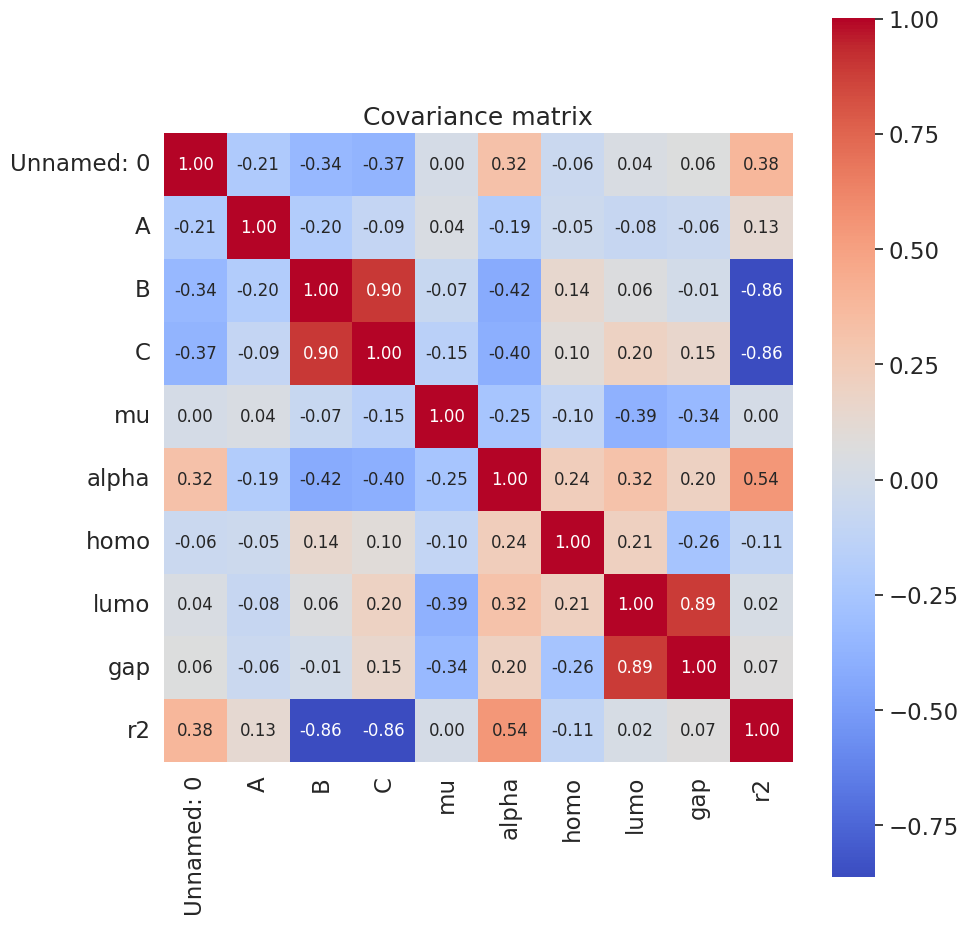

In [14]:
cols = features.columns[:10]

stdsc = StandardScaler()
X_std = stdsc.fit_transform(features[cols].iloc[:,range(10)].values)

cov_mat =np.cov(X_std.T)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix', size = 18)
plt.tight_layout()
plt.show()

In [17]:
FILTER_THRESHOLD = 0.9

reduced_features = features.drop('gap', axis=1)
cols = reduced_features.columns
stdsc = StandardScaler()
X_std = stdsc.fit_transform(reduced_features[cols].iloc[:,range(reduced_features.shape[1])].values)

cov_mat =np.cov(X_std.T)

cov_mat_df = pd.DataFrame(cov_mat, columns=cols)

upper_tri = cov_mat_df.where(
    np.triu(
        np.ones(cov_mat_df.shape), k=1).astype(bool)
        )

to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > FILTER_THRESHOLD)]
df2 = res.drop(to_drop, axis=1)

In [ ]:
X = features.drop('gap', axis = 1)
y = features['gap']

estimator = RandomForestRegressor(n_jobs=-1)

sfs1 = sfs(estimator,
           n_features_to_select=250,
           scoring='r2',
           cv=5)
sfs1 = sfs1.fit(X, y)
print(sfs1.support_)

In [19]:
df2.to_csv('df2.csv')